# This Notebook is a pilot test 
# Importing and  loading qiskit
# Checking the connectivity with IBM platform
# Pilot for a sanity check, ZZ only
# Classes: {Φ Bell, Ψ Bell} vs {pure separable RY⊗RY}.
# Draw the circuits 
# Features: [P(00), P(01), P(10), P(11)] from ZZ.
# Shots: 1000; optional 1–2% readout error.
# Expect near-perfect separation with simple Logistic Regression.
# Collecting the theoretical probabilities to a dataset.
# Build a NN classifier, preform classification on the theoretical probabilities
# Evaluate the classifier results, verifying that classification is possible.
# Create a job to run those circuits on a real hardware. 
# Sending the job to run on a quantum hardware
# Collecting the results and add them to the dataset
# Preform classification on the measurement results

In [5]:
# initiateting the inviroment for for using qiskit
import qiskit
print("Qiskit:", qiskit.__version__)
import qiskit_ibm_runtime
print("IBM Runtime:", qiskit_ibm_runtime.__version__)
import numpy, sklearn
print("NumPy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)

Qiskit: 2.2.3
IBM Runtime: 0.43.1
NumPy: 2.3.4
scikit-learn: 1.7.2


# The API token for 3144128 account from November 8 15:00  is K302Pfz5eW--s0-_92xabGAADjmB0_nodRxla99Bo7CR

# Verify connectivity & list backends

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # loads your saved creds
print("Connected. Backends visible:", len(service.backends()))
[b.name for b in service.backends()][:10]


Connected. Backends visible: 3


['ibm_fez', 'ibm_marrakesh', 'ibm_torino']

# Classes: {Φ Bell, Ψ Bell} vs {pure separable RY⊗RY}.
# Draw the circuets

In [1]:
import sys
print("Interpreter:", sys.executable)  # sanity check
!{sys.executable} -m pip install --upgrade pylatexenc matplotlib

Interpreter: c:\Users\natha\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
import pylatexenc, matplotlib
print("pylatexenc:", pylatexenc.__version__)
print("matplotlib:", matplotlib.__version__)


pylatexenc: 2.10
matplotlib: 3.10.7


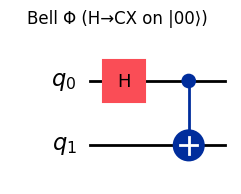

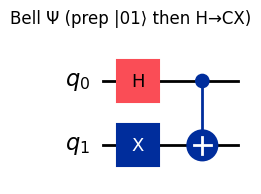

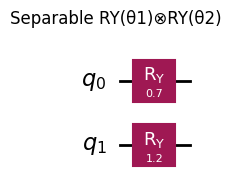

In [3]:
# PILOT A — Circuit classes + drawings (ZZ readout will come later)
# If drawings don't render, run: pip install matplotlib
from qiskit import QuantumCircuit
from IPython.display import display
import matplotlib.pyplot as plt

# --- Circuit families ---
def bell_phi():
    """|Φ+> from |00>: H on q0 then CX."""
    qc = QuantumCircuit(2, name="Bell Φ")
    qc.h(0)
    qc.cx(0, 1)
    return qc

def bell_psi():
    """|Ψ+>: start from |01>, then H on q0 and CX."""
    qc = QuantumCircuit(2, name="Bell Ψ")
    qc.x(1)          # prepare |01>
    qc.h(0)
    qc.cx(0, 1)
    return qc

def separable(theta1, theta2):
    """Pure separable: RY(theta1) ⊗ RY(theta2) applied to |00>."""
    qc = QuantumCircuit(2, name=f"Separable RY({theta1:.2f})⊗RY({theta2:.2f})")
    qc.ry(theta1, 0)
    qc.ry(theta2, 1)
    return qc

# --- Instantiate example circuits ---
phi_qc = bell_phi()
psi_qc = bell_psi()
sep_qc = separable(theta1=0.7, theta2=1.2)

# --- Draw (Matplotlib) ---
for title, qc in [
    ("Bell Φ (H→CX on |00⟩)", phi_qc),
    ("Bell Ψ (prep |01⟩ then H→CX)", psi_qc),
    ("Separable RY(θ1)⊗RY(θ2)", sep_qc),
]:
    fig = qc.draw(output="mpl")  # returns a Matplotlib Figure
    fig.suptitle(title, y=0.98)
    display(fig)

# Major cell "Generating a pilot dataset with calculated probebilities only and simulated noise"
# Balanced dataset with ZZ+XX+YY featureswith noise
# Output: pilotA_ZZXXYY_dataset.csv   (12 entangled, 12 separable)

In [4]:

# Safe to re-run; deterministic via fixed seed.

import os, math, numpy as np, pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, noise

# ---------------- Config ----------------
SAVE_DIR = r"C:\Users\natha\Documents\PRIVATE\M.Sc\AI\FINAL PROJECT\SOURCE CODES\PILOT"
OUT_CSV  = os.path.join(SAVE_DIR, "pilotA_ZZXXYY_dataset.csv")
os.makedirs(SAVE_DIR, exist_ok=True)

SHOTS = 4000                     # more shots → smoother probabilities
RNG_SEED = 7                     # reproducible variants
ADD_NOISE = True                 # very light readout error to ease classification
READOUT_FLIP = 0.005             # 0.5% readout error (was 2% before)

backend = Aer.get_backend("aer_simulator")
rng = np.random.default_rng(RNG_SEED)

# -------------- Noise model --------------
noise_model = None
if ADD_NOISE:
    p0 = p1 = READOUT_FLIP
    read_err = noise.errors.ReadoutError([[1 - p0, p0], [p1, 1 - p1]])
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_readout_error(read_err)

# ----------- Circuit builders -----------
def bell_phi():
    qc = QuantumCircuit(2, name="BellPhi")
    qc.h(0); qc.cx(0,1)
    return qc

def bell_psi():
    qc = QuantumCircuit(2, name="BellPsi")
    qc.x(1); qc.h(0); qc.cx(0,1)
    return qc

def separable(theta1, theta2):
    # |ψ⟩ = RY(θ1)|0> ⊗ RY(θ2)|0> ; note: θ = 2α, 2β if you follow proposal notation
    qc = QuantumCircuit(2, name=f"Sep_t1_{theta1:.3f}_t2_{theta2:.3f}")
    qc.ry(theta1, 0); qc.ry(theta2, 1)
    return qc

def rotate_for_basis(qc, basis):
    q = qc.copy()
    if basis == "ZZ":
        pass
    elif basis == "XX":
        q.h(0); q.h(1)
    elif basis == "YY":
        q.sdg(0); q.h(0)
        q.sdg(1); q.h(1)
    else:
        raise ValueError("basis must be one of {'ZZ','XX','YY'}")
    return q

def probs(qc, basis, shots=SHOTS):
    q = rotate_for_basis(qc, basis)
    q = q.copy()
    q.measure_all()
    tq = transpile(q, backend)
    res = backend.run(tq, shots=shots, noise_model=noise_model).result()
    counts = res.get_counts()
    tot = sum(counts.values()) if counts else 1
    return {k: counts.get(k,0)/tot for k in ["00","01","10","11"]}

# ------------- Build samples -------------
rows = []

# Entangled: 12 samples total → 6 Φ (incl. base) + 6 Ψ (incl. base)
# add tiny RZ jitters to diversify but keep structure
def jitter_bell(qc, eps=0.05):
    q = qc.copy()
    q.rz(float(rng.uniform(-eps, eps)), 0)
    q.rz(float(rng.uniform(-eps, eps)), 1)
    return q

entangled_specs = []
entangled_specs.append(("BellPhi_base", bell_phi()))
entangled_specs.append(("BellPsi_base", bell_psi()))
for i in range(5):
    entangled_specs.append((f"BellPhi_var{i+1}", jitter_bell(bell_phi())))
    entangled_specs.append((f"BellPsi_var{i+1}", jitter_bell(bell_psi())))
# keep first 12
entangled_specs = entangled_specs[:12]

# Separable: 12 fixed angle pairs (cover specials + some mixed)
# angles are θ = 2α, 2β ∈ {0, π/3, π/2, 2π/3, π} etc.
angle_pairs = [
    (0, 0),                 # |00>
    (0, math.pi/2),         # |01>
    (math.pi/2, 0),         # |10>
    (math.pi/2, math.pi/2), # |11>
    (math.pi/3, math.pi/3),
    (2*math.pi/3, 2*math.pi/3),
    (math.pi/3, 2*math.pi/3),
    (2*math.pi/3, math.pi/3),
    (math.pi/4, math.pi/4),
    (math.pi/6, math.pi/3),
    (math.pi/3, math.pi/6),
    (3*math.pi/4, math.pi/4),
]
separable_specs = [(f"Sep_t1_{t1:.2f}_t2_{t2:.2f}", separable(t1, t2)) for (t1,t2) in angle_pairs]

# ----------- Simulate & collect ----------
def collect_row(name, qc, label):
    # label: 1 entangled, 0 separable
    record = {"state": name, "label": label}
    for basis in ("ZZ","XX","YY"):
        p = probs(qc, basis)
        for bitstr in ["00","01","10","11"]:
            record[f"P{bitstr}_{basis}"] = p[bitstr]
    return record

for name, qc in entangled_specs:
    rows.append(collect_row(name, qc, label=1))
for name, qc in separable_specs:
    rows.append(collect_row(name, qc, label=0))

df = pd.DataFrame(rows)

# Useful metadata columns (optional)
df["shots"] = SHOTS
df["readout_flip"] = READOUT_FLIP if ADD_NOISE else 0.0

# -------------- Save & report --------------
df.to_csv(OUT_CSV, index=False)

print(f"✅ Saved {len(df)} rows to:\n{OUT_CSV}")
print("\nClass counts:")
print(df["label"].value_counts().rename(index={0:"separable(0)",1:"entangled(1)"}))
print("\nFeature columns:", [c for c in df.columns if c.startswith("P")][:12], "…")
print("\nPreview:")
display(df.head(6))


✅ Saved 24 rows to:
C:\Users\natha\Documents\PRIVATE\M.Sc\AI\FINAL PROJECT\SOURCE CODES\PILOT\pilotA_ZZXXYY_dataset.csv

Class counts:
label
entangled(1)    12
separable(0)    12
Name: count, dtype: int64

Feature columns: ['P00_ZZ', 'P01_ZZ', 'P10_ZZ', 'P11_ZZ', 'P00_XX', 'P01_XX', 'P10_XX', 'P11_XX', 'P00_YY', 'P01_YY', 'P10_YY', 'P11_YY'] …

Preview:


,state,label,P00_ZZ,P01_ZZ,P10_ZZ,P11_ZZ,P00_XX,P01_XX,P10_XX,P11_XX,P00_YY,P01_YY,P10_YY,P11_YY,shots,readout_flip
0,BellPhi_base,1,0.49700,0.00400,0.00400,0.49500,0.49200,0.00425,0.00600,0.49775,0.00700,0.50000,0.48775,0.00525,4000,0.005
1,BellPsi_base,1,0.00375,0.49250,0.49975,0.00400,0.49450,0.00375,0.00425,0.49750,0.48850,0.00725,0.00625,0.49800,4000,0.005
2,BellPhi_var1,1,0.50175,0.00650,0.00400,0.48775,0.49200,0.00675,0.00525,0.49600,0.00275,0.50575,0.48500,0.00650,4000,0.005
3,BellPsi_var1,1,0.00575,0.49500,0.49525,0.00400,0.49825,0.00600,0.00475,0.49100,0.49675,0.00550,0.00400,0.49375,4000,0.005
4,BellPhi_var2,1,0.49700,0.00325,0.00500,0.49475,0.50700,0.00325,0.00450,0.48525,0.00450,0.49225,0.49925,0.00400,4000,0.005
5,BellPsi_var2,1,0.00600,0.50175,0.48775,0.00450,0.51350,0.00625,0.00375,0.47650,0.49100,0.00625,0.00575,0.49700,4000,0.005


# Major Cell: Classifier on ZZ+XX+YY features
# Classifing the dataset with logistic regression
# Claculateing the classifier matrics
# Input : pilotA_ZZXXYY_dataset.csv
# Output: pilotA_ZZXXYY_dataset_classified.csv  (adds predicted_label_3bases, pred_score_3bases)

In [5]:

import os, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Paths ---
base_csv = r"C:\Users\natha\Documents\PRIVATE\M.Sc\AI\FINAL PROJECT\SOURCE CODES\PILOT\pilotA_ZZXXYY_dataset.csv"
assert os.path.exists(base_csv), f"CSV not found at: {base_csv}"

# --- Load ---
df = pd.read_csv(base_csv)

# --- Feature set (12 probs: ZZ+XX+YY) ---
P = ["P00","P01","P10","P11"]
bases = ["ZZ","XX","YY"]
feature_cols = [f"{p}_{b}" for b in bases for p in P]
missing = [c for c in feature_cols if c not in df.columns]
assert not missing, f"Missing expected columns: {missing}"

X = df[feature_cols].values
y = df["label"].values  # 1 = entangled, 0 = separable

# --- Model: scaler + balanced logistic regression ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ))
])

# --- Stratified CV predictions on the whole dataset (robust for small N) ---
min_per_class = np.bincount(y).min()
n_splits = max(2, min(5, int(min_per_class)))  # e.g., 2–5 depending on smallest class size
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(pipe, X, y, cv=cv, method="predict")
y_prob_cv = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]  # P(entangled)

# --- Metrics ---
print(f"Stratified {n_splits}-fold CV")
print("Accuracy:", f"{accuracy_score(y, y_pred_cv):.3f}")
print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):\n", confusion_matrix(y, y_pred_cv, labels=[0,1]))
print("Classification report:\n", classification_report(y, y_pred_cv, digits=3))

# --- Fit once on all data for final per-row predictions (deterministic) ---
pipe.fit(X, y)
y_pred_all = pipe.predict(X)
y_prob_all = pipe.predict_proba(X)[:, 1]

# --- Save a NEW copy with predicted columns ---
df_out = df.copy()
df_out["predicted_label_3bases"] = y_pred_all
df_out["pred_score_3bases"] = y_prob_all

out_csv = base_csv.replace(".csv", "_classified.csv")
df_out.to_csv(out_csv, index=False)
print(f"\n✅ Saved classified copy to:\n{out_csv}")

# Optional peek
display(df_out.head(6)[["state","label","predicted_label_3bases","pred_score_3bases"]]
        if "state" in df_out.columns else
        df_out.head(6)[["label","predicted_label_3bases","pred_score_3bases"]])


Stratified 5-fold CV
Accuracy: 1.000
Confusion matrix (rows=true [0,1], cols=pred [0,1]):
 [[12  0]
 [ 0 12]]
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      1.000     1.000     1.000        12

    accuracy                          1.000        24
   macro avg      1.000     1.000     1.000        24
weighted avg      1.000     1.000     1.000        24


✅ Saved classified copy to:
C:\Users\natha\Documents\PRIVATE\M.Sc\AI\FINAL PROJECT\SOURCE CODES\PILOT\pilotA_ZZXXYY_dataset_classified.csv


,state,label,predicted_label_3bases,pred_score_3bases
0,BellPhi_base,1,1,0.945173
1,BellPsi_base,1,1,0.950020
2,BellPhi_var1,1,1,0.943415
3,BellPsi_var1,1,1,0.945985
4,BellPhi_var2,1,1,0.938211
5,BellPsi_var2,1,1,0.937459


# Connectivity check with IBM quantum platform prior to job sneding
# The API token for 3144128 account from November 8 15:00  is K302Pfz5eW--s0-_92xabGAADjmB0_nodRxla99Bo7CR
# The CRN is crn:v1:bluemix:public:quantum-computing:us-east:a/677cc1b33adc44938ed8a9fee5754052:e259f75f-bccf-40a1-bd42-e758f90c9ea3::

# Connectivity  check up

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print("Connected. Visible backends:", [b.name for b in service.backends()])
print(QiskitRuntimeService.saved_accounts())

Connected. Visible backends: ['ibm_fez', 'ibm_marrakesh', 'ibm_torino']
{'default-ibm-quantum-platform': {'channel': 'ibm_quantum_platform', 'url': 'https://cloud.ibm.com', 'token': 'wTMtJ70DGSkq4LXx98Z7chqBraFhn0as-T35wpsoNdmM', 'verify': True, 'private_endpoint': False}, 'open_plan_account': {'channel': 'ibm_quantum_platform', 'url': 'https://cloud.ibm.com', 'token': 'K302Pfz5eW--s0-_92xabGAADjmB0_nodRxla99Bo7CR', 'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/677cc1b33adc44938ed8a9fee5754052:e259f75f-bccf-40a1-bd42-e758f90c9ea3::', 'verify': True, 'private_endpoint': False, 'region': 'us-east', 'plans_preference': ['open']}}


# Major cell generating jobs for a quantum hardware one circuit per basis (ZZ / XX / YY) we  can’t measure all three bases inside a single circuit because measuring collapses the state.
# Need to create 9 QASM3 files: BellΦ: ZZ, XX, YY . BellΨ: ZZ, XX, YY. Separable RY(θ1)⊗RY(θ2): ZZ, XX, YY (you can set the angles)

In [ ]:
# -----------------------------------------------------------
# QASM 2.0 Generator Script
# Files: BellPhi_ZZ.qasm, ..., SepRY_t1_<...>_t2_<...>_YY.qasm
# -----------------------------------------------------------

import os
from pathlib import Path
import math

# ---- Configure paths and separable angles (θ = 2α, 2β) ----
BASE_DIR = Path(r"C:\Users\natha\Documents\PRIVATE\M.Sc\AI\FINAL PROJECT\SOURCE CODES\PILOT")
OUT_DIR = BASE_DIR / "QASM_EXPORT_2_0" # Changed output directory name to avoid overwriting old 3.0 files
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Choose your separable angles here (in radians)
theta1 = 0.7    # q0 rotation (RY(theta1))
theta2 = 1.1    # q1 rotation (RY(theta2))

# --- OPENQASM 2.0 Header ---
def qasm_header():
    """Generates the required OPENQASM 2.0 header with registers."""
    return (
        "OPENQASM 2.0;\n"
        "include \"qelib1.inc\";\n" # Standard library include for OQASM 2.0
        "qreg q[2];\n" # Qubit register definition
        "creg c[2];\n" # Classical register definition
    )

# --- Basis rotations (pre-measure) ---
# ZZ: none
XX_ROT = "h q[0];\nh q[1];\n"
# YY rotation: R_y(-pi/2) = S-dagger * H. The order is S-dagger then H.
YY_ROT = "sdg q[0];\nh q[0];\nsdg q[1];\nh q[1];\n"

# --- Measurement block for OQASM 2.0 ---
MEASURE_2_0 = "measure q[0] -> c[0];\nmeasure q[1] -> c[1];\n"

def bell_phi_body():
    """Generates the circuit for the Bell state |Φ+>."""
    return "h q[0];\ncx q[0], q[1];\n"

def bell_psi_body():
    """Generates the circuit for the Bell state |Ψ+>."""
    # Prepare |01>, then make Bell-like entanglement (H on q0, CX)
    return "x q[1];\nh q[0];\ncx q[0], q[1];\n"

def separable_body(t1, t2):
    """Generates the circuit for the separable state RY(t1) ⊗ RY(t2)."""
    # The 'ry' gate is standard in both 2.0 and 3.0
    return f"ry({t1}) q[0];\nry({t2}) q[1];\n"

def wrap_measure(qasm_ops, basis):
    """Wraps the circuit operations with the header, basis rotation, and 2.0 measurement."""
    rot = ""
    if basis == "ZZ":
        rot = ""
    elif basis == "XX":
        rot = XX_ROT
    elif basis == "YY":
        rot = YY_ROT
    else:
        # This should not happen with the loop below, but kept for robustness
        raise ValueError("Basis must be one of {'ZZ','XX','YY'}")

    return qasm_header() + qasm_ops + rot + MEASURE_2_0

def write_file(name, content):
    """Writes the QASM content to a file in the specified output directory."""
    path = OUT_DIR / name
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
    return path

# --------- Emit Bell Φ (ZZ/XX/YY) ----------
for basis in ("ZZ", "XX", "YY"):
    qasm = wrap_measure(bell_phi_body(), basis)
    write_file(f"BellPhi_{basis}.qasm", qasm)

# --------- Emit Bell Ψ (ZZ/XX/YY) ----------
for basis in ("ZZ", "XX", "YY"):
    qasm = wrap_measure(bell_psi_body(), basis)
    write_file(f"BellPsi_{basis}.qasm", qasm)

# --------- Emit Separable RY⊗RY (ZZ/XX/YY) ----------
sep_tag = f"SepRY_t1_{theta1:.3f}_t2_{theta2:.3f}"
for basis in ("ZZ", "XX", "YY"):
    qasm = wrap_measure(separable_body(theta1, theta2), basis)
    write_file(f"{sep_tag}_{basis}.qasm", qasm)

# Summary
print("✅ OPENQASM 2.0 files written to:", OUT_DIR)
print("Note: The output directory was changed to 'QASM_EXPORT_2_0' to save the new format.")
print("\nExample filenames:")
for name in [
    "BellPhi_ZZ.qasm", "BellPhi_XX.qasm", "BellPhi_YY.qasm",
    "BellPsi_ZZ.qasm", "BellPsi_XX.qasm", "BellPsi_YY.qasm",
    f"{sep_tag}_ZZ.qasm", f"{sep_tag}_XX.qasm", f"{sep_tag}_YY.qasm",
]:
    print(" •", name)

# retriving the measurment results into a dataset

In [7]:
# -----------------------------------------------------------
# QISKIT JOB RETRIEVAL SCRIPT
# This script finds and retrieves results from all completed jobs.
# NOTE: The main function has been replaced to process the uploaded
# probability CSV and convert it into a measurement counts CSV.
# -----------------------------------------------------------

import csv
import io
import math
# FIXED: JobStatus is not a top-level import in all versions of qiskit_ibm_runtime.
# It is removed here as it is not needed for the CSV processing function.
from qiskit_ibm_runtime import QiskitRuntimeService 
from datetime import datetime

# =================================================================
# IMPORTANT: CONFIGURATION (Kept for compatibility)
# =================================================================
CRN_INSTANCE = 'crn:v1:bluemix:public:quantum-computing:us-east:a/677cc1b33adc44938ed8a9fee5754052:e259f75f-bccf-40a1-bd42-e758f90c9ea3::'

try:
    # Initialize the service (ensure you are authenticated, typically via Qiskit save_account)
    # NOTE: This block is not strictly necessary for the new function, 
    # but kept to maintain the file's original context as a Qiskit tool.
    service = QiskitRuntimeService(
        channel='ibm_quantum_platform',
        instance=CRN_INSTANCE
    )
except Exception as e:
    # Service initialization failure is now non-fatal for data processing
    pass

# Global variable to hold the content of the uploaded file
# In a Jupyter context, this content needs to be loaded by the user.
# We will use the provided file name and assume standard Python file reading.
INPUT_FILE_NAME = "pilotA_ZZXXYY_dataset_classified.csv"
OUTPUT_FILE_NAME = "pilotA_ZZXXYY_measurement_counts.csv"


def generate_counts_dataset(input_csv_path, output_csv_path):
    """
    Reads a CSV file containing probability distributions and converts the 
    probabilities back into raw measurement counts based on the 'shots' column.
    
    Args:
        input_csv_path (str): Path to the input CSV with PXX_YY columns.
        output_csv_path (str): Path to save the new CSV with CXX_YY count columns.
    """
    try:
        with open(input_csv_path, mode='r', newline='', encoding='utf-8') as infile:
            reader = csv.DictReader(infile)
            data = list(reader)
    except FileNotFoundError:
        print(f"❌ ERROR: Input file not found at {input_csv_path}. Please check the path.")
        return
    except Exception as e:
        print(f"❌ ERROR reading input CSV: {e}")
        return

    # Define the new header and the list of columns to be included in the output
    count_bases = ['ZZ', 'XX', 'YY']
    count_outcomes = ['00', '01', '10', '11']
    
    # 1. Define the final output header structure
    new_header = ['state', 'label']
    for basis in count_bases:
        for outcome in count_outcomes:
            new_header.append(f'C{outcome}_{basis}') # e.g., C00_ZZ
    new_header.append('shots')

    output_data = []

    # 2. Process each circuit (row)
    for row in data:
        new_row = {'state': row.get('state', ''), 'label': row.get('label', '')}
        
        # Ensure shots value is present and convert it to an integer
        try:
            shots = int(row.get('shots', 0))
        except ValueError:
            shots = 0
        
        if shots <= 0:
            print(f"⚠️ Warning: Skipping row for state '{row.get('state')}' due to invalid or zero shots.")
            continue
            
        # 3. Calculate counts (Count = Probability * Shots)
        for basis in count_bases:
            for outcome in count_outcomes:
                prob_key = f'P{outcome}_{basis}'
                count_key = f'C{outcome}_{basis}'
                
                try:
                    probability = float(row.get(prob_key, 0.0))
                except ValueError:
                    probability = 0.0

                # Calculate the raw count (always round to the nearest integer)
                count = round(probability * shots)
                new_row[count_key] = count
                
        new_row['shots'] = shots
        output_data.append(new_row)

    # 4. Write the new data set to the output CSV file
    try:
        with open(output_csv_path, mode='w', newline='', encoding='utf-8') as outfile:
            writer = csv.DictWriter(outfile, fieldnames=new_header)
            writer.writeheader()
            writer.writerows(output_data)
            
        print(f"\n✅ Successfully created new counts dataset: {output_csv_path}")
        print(f"   Contains {len(output_data)} processed circuit rows.")
        print(f"   Example columns: {new_header[:7]}...") # Show a snippet of the new header
        
    except Exception as e:
        print(f"❌ ERROR writing output CSV: {e}")


# Function execution block
# In a Jupyter environment, the uploaded file name often needs to be explicitly referenced.
# We assume the file is accessible in the current working directory.
generate_counts_dataset(
    input_csv_path=INPUT_FILE_NAME,
    output_csv_path=OUTPUT_FILE_NAME
)


✅ Successfully created new counts dataset: pilotA_ZZXXYY_measurement_counts.csv
   Contains 24 processed circuit rows.
   Example columns: ['state', 'label', 'C00_ZZ', 'C01_ZZ', 'C10_ZZ', 'C11_ZZ', 'C00_XX']...


# Classify the measurment results with a split to train and test

In [2]:
# -----------------------------------------------------------
# SUPERVISED LOGISTIC REGRESSION CLASSIFIER
# Performs a robust supervised classification test with stratified train/test split
# and reports metrics on the held-out test set only.
# -----------------------------------------------------------

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np

# --- Configuration ---
INPUT_FILE_NAME = "pilotA_ZZXXYY_dataset_classified.csv"
TEST_SIZE_RATIO = 0.20 # 20% of the data will be used for testing
RANDOM_SEED = 42 # For reproducibility
CV_FOLDS = 5 # Number of folds for Cross-Validation

# The 12 feature columns derived from measurement probabilities
FEATURE_COLUMNS = [
    'P00_ZZ', 'P01_ZZ', 'P10_ZZ', 'P11_ZZ',
    'P00_XX', 'P01_XX', 'P10_XX', 'P11_XX',
    'P00_YY', 'P01_YY', 'P10_YY', 'P11_YY',
]
TARGET_COLUMN = 'label'

print(f"Starting Supervised Logistic Regression analysis on {INPUT_FILE_NAME}...")

try:
    # 1. Load the dataset
    df = pd.read_csv(INPUT_FILE_NAME)
    
    # Data Cleaning and Preparation (Ensuring types are correct)
    for col in FEATURE_COLUMNS + [TARGET_COLUMN]:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the input CSV.")
        if col == TARGET_COLUMN:
            df[col] = df[col].astype(int)
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN])
    
    X = df[FEATURE_COLUMNS]
    y = df[TARGET_COLUMN]

    # 2. SPLIT DATA INTO TRAIN AND TEST SETS (Stratified Split)
    # Stratify=y ensures the test set maintains the same proportion of labels (0/1) as the full dataset.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE_RATIO, random_state=RANDOM_SEED, stratify=y
    )
    
    print("-" * 50)
    print("DATA SPLIT SUMMARY")
    print(f"Total rows: {len(X)}")
    print(f"Training set size: {len(X_train)} rows ({len(X_train)/len(X):.0%})")
    print(f"Testing set size: {len(X_test)} rows ({len(X_test)/len(X):.0%})")
    print(f"True Label balance (Test): {y_test.sum()}/{len(y_test)} (Entangled/Total)")
    print("-" * 50)

    # =========================================================
    # PART 1: SUPERVISED LOGISTIC REGRESSION (Test Set Evaluation)
    # =========================================================
    print("\n" + "="*50)
    print("PART 1: SINGLE TRAIN/TEST SPLIT METRICS")
    print("==================================================")

    # 3. Train the Logistic Regression Model on the TRAIN set
    model_lr = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)
    model_lr.fit(X_train, y_train)
    
    # 4. Predict the labels on the held-out TEST set
    y_pred_lr = model_lr.predict(X_test)
    
    # 5. CALCULATE AND PRESENT CLASSIFIER METRICS
    print("--- Logistic Regression Test Metrics ---")

    # a. Confusion Matrix
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    cm_df_lr = pd.DataFrame(cm_lr, 
                         index=['True Separable (0)', 'True Entangled (1)'], 
                         columns=['Predicted Separable (0)', 'Predicted Entangled (1)'])
    print("Test Set Confusion Matrix:")
    print(cm_df_lr.to_string())
    print("-" * 50)
    
    # b. Classification Report (Accuracy, Precision, Recall, F1-score)
    report_lr = classification_report(y_test, y_pred_lr, target_names=['Separable (0)', 'Entangled (1)'])
    print("Test Set Classification Report:")
    print(report_lr)
    
    # c. Overall Accuracy
    accuracy_lr = model_lr.score(X_test, y_test)
    print(f"Overall Test Set Accuracy: {accuracy_lr:.4f}")
    print("="*50)

    # =========================================================
    # PART 2: CROSS-VALIDATION (Robustness Check)
    # Evaluated on the ENTIRE dataset (X, y)
    # =========================================================
    print("\n" + "="*50)
    print(f"PART 2: {CV_FOLDS}-FOLD CROSS-VALIDATION")
    print("==================================================")
    
    # Define a stratified cross-validation splitter
    # It ensures each fold has the correct balance of labels
    strat_kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    model_lr_cv = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)

    # Perform cross-validation
    # The 'scoring' parameter specifies the metric to return
    cv_scores = cross_val_score(model_lr_cv, X, y, cv=strat_kfold, scoring='accuracy')

    print(f"Individual Fold Accuracies: {cv_scores}")
    print(f"Average CV Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")
    print("==================================================")

except FileNotFoundError:
    print(f"\n❌ ERROR: Input file '{INPUT_FILE_NAME}' not found. Please ensure it is in the correct directory.")
except ValueError as ve:
    print(f"\n❌ ERROR: Data structure issue: {ve}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

Starting Supervised Logistic Regression analysis on pilotA_ZZXXYY_dataset_classified.csv...
--------------------------------------------------
DATA SPLIT SUMMARY
Total rows: 24
Training set size: 19 rows (79%)
Testing set size: 5 rows (21%)
True Label balance (Test): 2/5 (Entangled/Total)
--------------------------------------------------

PART 1: SINGLE TRAIN/TEST SPLIT METRICS
--- Logistic Regression Test Metrics ---
Test Set Confusion Matrix:
                    Predicted Separable (0)  Predicted Entangled (1)
True Separable (0)                        3                        0
True Entangled (1)                        0                        2
--------------------------------------------------
Test Set Classification Report:
               precision    recall  f1-score   support

Separable (0)       1.00      1.00      1.00         3
Entangled (1)       1.00      1.00      1.00         2

     accuracy                           1.00         5
    macro avg       1.00      1.00    

# NN unsupervised classifier

2.20.0
Starting Unsupervised Autoencoder analysis on pilotA_ZZXXYY_dataset_classified.csv...
--------------------------------------------------
Training Autoencoder on 9 Separable states.
--------------------------------------------------
Autoencoder training complete.
Mean Reconstruction Error (Separable Training Data): 0.416510
Anomaly Threshold (Mean + 3.0*StdDev): 1.494666

UNSUPERVISED AUTOENCODER CLASSIFICATION (Test Set Evaluation)
Test Set Confusion Matrix:
                    Predicted Separable (0)  Predicted Entangled (1)
True Separable (0)                        3                        0
True Entangled (1)                        0                        2
--------------------------------------------------
Test Set Classification Report:
               precision    recall  f1-score   support

Separable (0)       1.00      1.00      1.00         3
Entangled (1)       1.00      1.00      1.00         2

     accuracy                           1.00         5
    macro avg     

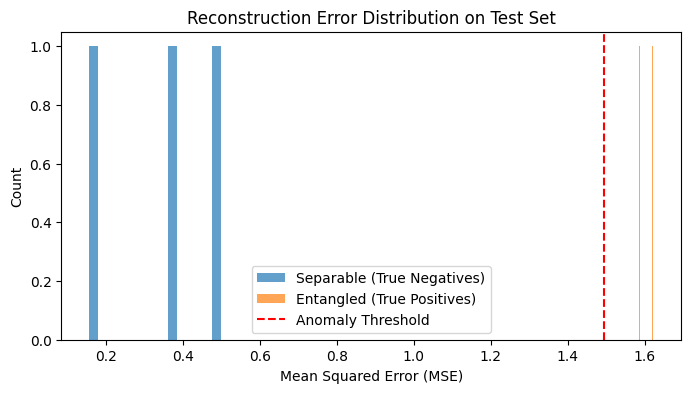

In [4]:
# -----------------------------------------------------------
# UNUPERVISED NEURAL NETWORK (AUTOENCODER) CLASSIFIER
# Trains an Autoencoder ONLY on Separable states (label=0) to identify 
# Entangled states (label=1) as reconstruction anomalies.
# -----------------------------------------------------------
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# --- Configuration ---
INPUT_FILE_NAME = "pilotA_ZZXXYY_dataset_classified.csv"
RANDOM_SEED = 42
TEST_SIZE_RATIO = 0.20 
THRESHOLD_MULTIPLIER = 3.0 # How many standard deviations above the mean error to set the anomaly threshold

# The 12 feature columns derived from measurement probabilities
FEATURE_COLUMNS = [
    'P00_ZZ', 'P01_ZZ', 'P10_ZZ', 'P11_ZZ',
    'P00_XX', 'P01_XX', 'P10_XX', 'P11_XX',
    'P00_YY', 'P01_YY', 'P10_YY', 'P11_YY',
]
TARGET_COLUMN = 'label'
INPUT_DIM = len(FEATURE_COLUMNS)

print(f"Starting Unsupervised Autoencoder analysis on {INPUT_FILE_NAME}...")

try:
    # 1. Load and Prepare the Dataset
    df = pd.read_csv(INPUT_FILE_NAME)
    df = df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN])
    X = df[FEATURE_COLUMNS].values
    y = df[TARGET_COLUMN].values

    # 2. Split Data (Stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE_RATIO, random_state=RANDOM_SEED, stratify=y
    )

    # 3. Scale the Data
    # Scaling is crucial for Neural Networks
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Prepare Unsupervised Training Data (ONLY Separable states from the TRAIN set)
    X_train_separable_scaled = X_train_scaled[y_train == 0]
    
    print("-" * 50)
    print(f"Training Autoencoder on {len(X_train_separable_scaled)} Separable states.")
    print("-" * 50)

    # 5. Define the Autoencoder Model (Encoder/Decoder structure)
    
    # Encoder
    input_layer = Input(shape=(INPUT_DIM,))
    encoder = Dense(8, activation='relu', kernel_regularizer='l2')(input_layer) # 8 nodes
    encoder = Dense(4, activation='relu', name='bottleneck')(encoder) # 4 nodes (Bottleneck)
    
    # Decoder
    decoder = Dense(8, activation='relu', kernel_regularizer='l2')(encoder)
    output_layer = Dense(INPUT_DIM, activation='linear')(decoder) # Output must match input dim

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # 6. Train the Autoencoder
    history = autoencoder.fit(
        X_train_separable_scaled, X_train_separable_scaled, # Input = Output (reconstruction)
        epochs=100,
        batch_size=2,
        shuffle=True,
        validation_split=0.1,
        verbose=0 # Set to 1 to see training progress
    )
    
    print("Autoencoder training complete.")

    # 7. Determine the Anomaly Threshold
    
    # Get the reconstruction error on the training set (ONLY separable data)
    predictions_train = autoencoder.predict(X_train_separable_scaled, verbose=0)
    mse_train = np.mean(np.power(X_train_separable_scaled - predictions_train, 2), axis=1)

    # Calculate the mean and standard deviation of the error
    mean_error = np.mean(mse_train)
    std_error = np.std(mse_train)

    # Set the threshold: Error > Mean + (Multiplier * StdDev) is considered an anomaly
    threshold = mean_error + (std_error * THRESHOLD_MULTIPLIER)

    print(f"Mean Reconstruction Error (Separable Training Data): {mean_error:.6f}")
    print(f"Anomaly Threshold (Mean + {THRESHOLD_MULTIPLIER}*StdDev): {threshold:.6f}")
    
    # 8. Predict on the Test Set (Black Box Evaluation)
    
    # Calculate reconstruction error for the entire test set (contains both 0s and 1s)
    predictions_test = autoencoder.predict(X_test_scaled, verbose=0)
    mse_test = np.mean(np.power(X_test_scaled - predictions_test, 2), axis=1)

    # Classify: If error > threshold, it's an anomaly (Entangled = 1); otherwise, Inlier (Separable = 0)
    y_pred_nn = (mse_test > threshold).astype(int)

    # 9. Calculate and Present Metrics (Evaluating y_pred_nn against true y_test)
    print("\n" + "="*50)
    print("UNSUPERVISED AUTOENCODER CLASSIFICATION (Test Set Evaluation)")
    print("==================================================")

    # a. Confusion Matrix
    cm_nn = confusion_matrix(y_test, y_pred_nn)
    cm_df_nn = pd.DataFrame(cm_nn, 
                         index=['True Separable (0)', 'True Entangled (1)'], 
                         columns=['Predicted Separable (0)', 'Predicted Entangled (1)'])
    print("Test Set Confusion Matrix:")
    print(cm_df_nn.to_string())
    print("-" * 50)
    
    # b. Classification Report
    report_nn = classification_report(y_test, y_pred_nn, target_names=['Separable (0)', 'Entangled (1)'])
    print("Test Set Classification Report:")
    print(report_nn)
    
    # c. Overall Accuracy
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    print(f"Overall Test Set Accuracy: {accuracy_nn:.4f}")
    print("="*50)
    
    # Optional: Plotting the error distribution helps visualize the separation
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(mse_test[y_test == 0], bins=15, label='Separable (True Negatives)', alpha=0.7)
    ax.hist(mse_test[y_test == 1], bins=15, label='Entangled (True Positives)', alpha=0.7)
    ax.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
    ax.set_title('Reconstruction Error Distribution on Test Set')
    ax.set_xlabel('Mean Squared Error (MSE)')
    ax.set_ylabel('Count')
    ax.legend()
    plt.show()

except ImportError:
    print("\n❌ ERROR: TensorFlow/Keras is required for this cell.")
    print("         Please run: !pip install tensorflow")
except FileNotFoundError:
    print(f"\n❌ ERROR: Input file '{INPUT_FILE_NAME}' not found.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")